# The Cancer Genome Atlas (TCGA) Breast Invasive Carcinoma (BRCA) Dataset

This dataset measures the genetic and biological effect of BRCA in a cohort of 1000+ patients. 

For this project we have subset this dataset with common and unique patients across three datasets : 
 - Transcriptomcs (mRNA)
 - Epigentics (DNAm)
 - Proteomics (RPPA)

The prediction taks in this project is tumour subtype classification. It has been shown that, depending on the specific tumour subtype, outcomes for women with BRCA will vary significantly. Therefore, being able to accruately stratify by subtype is an important characterisation for this cancer and will affect the treatment course decided by the physician. 

The different subtypes present in this dataset are : 
- Luminal A (LumA)
- Luminal B (LumB)
- Basal
- HER2

Each of these modalities will capture a different aspect of the disease, thus many methods which can integrate them have become popular. 

In this short notebook, we will look at the different data types and give some information on their biological aspects. 

In [87]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from palettable import wesanderson as wes

data_dir = "./../data/TCGA-BRCA/"
mod = ["mRNA", "DNAm" , "RPPA"]

In [88]:
data = {}
for omic in mod : 
   with open(f"{data_dir}{omic}.pkl", "rb") as f:  # 'rb' = read binary
    data[omic] = pickle.load(f) 

## Transcriptomics (mRNA)

Transcriptomics looks at all RNA in a cell to see which genes are “on” and how strongly.

This gene expression dataset is a table of gene activity levels across breast cancer (BRCA) tissue samples

Numbers come from RNA sequencing; higher values mean more of that gene’s RNA was detected.

mRNA and genes should have a very similar distribution in a population, but when a person has a disease, the disease can cause a large change in a genes expression causing it to become over/under expressed. 

In [89]:
data['mRNA']["expr"].head()

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288611.1,ENSG00000288612.1,ENSG00000288638.1,ENSG00000288648.1,ENSG00000288657.1,ENSG00000288658.1,ENSG00000288663.1,ENSG00000288670.1,ENSG00000288674.1,ENSG00000288675.1
TCGA-E9-A228,11.220890,4.194486,10.680243,10.487409,9.448297,9.408937,10.505433,11.871306,10.985411,11.401380,...,3.308428,5.408347,2.843467,2.843467,2.843467,6.249685,5.485041,8.864766,4.498478,4.194486
TCGA-HN-A2NL,12.279388,3.347630,11.422199,10.338415,9.834559,8.123745,10.559379,10.412459,10.856693,11.637981,...,4.373216,4.732522,3.552924,2.843467,2.843467,6.432414,5.938534,8.195267,4.879134,6.307971
TCGA-OL-A5D7,11.436488,4.204181,11.338812,10.696614,11.024408,9.917112,9.852083,10.494274,10.290863,12.049691,...,3.469872,6.238882,2.843467,2.843467,2.843467,5.977719,5.808513,9.188112,4.707533,6.365531
TCGA-A2-A3KC,11.511191,5.737801,10.834398,10.931552,9.698790,9.609320,11.893211,11.046319,10.422642,11.226144,...,3.354080,5.578962,2.843467,3.561911,2.843467,4.064020,5.762593,8.621993,4.459940,5.431014
TCGA-A2-A0YI,12.431769,5.762581,10.823070,10.601755,8.992869,9.630460,11.674870,11.553497,11.183243,11.169297,...,3.506481,5.608277,2.843467,3.314332,2.843467,3.773210,5.460744,8.646323,4.210609,4.343591


In [90]:
data['mRNA']["meta"]

,patient,race,gender,sample_type,paper_BRCA_Subtype_PAM50,sizeFactor,replaceable
TCGA-E9-A228,TCGA-E9-A228,white,female,Primary Tumor,LumB,1.329814,True
TCGA-HN-A2NL,TCGA-HN-A2NL,not reported,female,Primary Tumor,Basal,1.129338,True
TCGA-OL-A5D7,TCGA-OL-A5D7,black or african american,female,Primary Tumor,Basal,0.727540,True
TCGA-A2-A3KC,TCGA-A2-A3KC,black or african american,female,Primary Tumor,LumA,1.100696,True
TCGA-A2-A0YI,TCGA-A2-A0YI,white,female,Primary Tumor,LumA,1.296389,True
...,...,...,...,...,...,...,...
TCGA-A2-A0T2,TCGA-A2-A0T2,white,female,Primary Tumor,Basal,0.786613,True
TCGA-E9-A249,TCGA-E9-A249,white,female,Primary Tumor,LumB,1.435994,True
TCGA-C8-A274,TCGA-C8-A274,asian,female,Primary Tumor,LumB,1.311352,True
TCGA-BH-A0C0,TCGA-BH-A0C0,white,female,Primary Tumor,LumB,0.802390,True


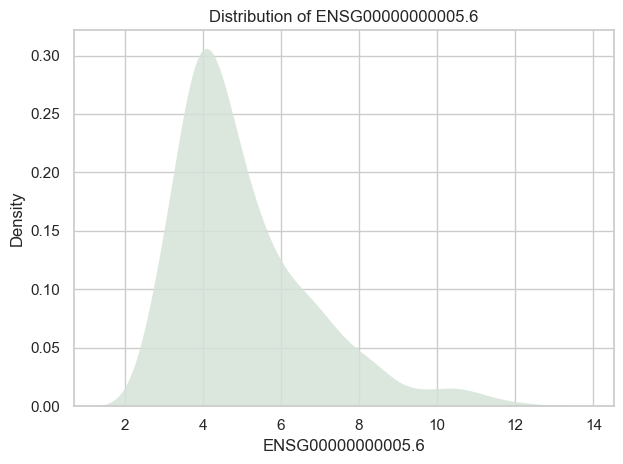

In [91]:
color = wes.Darjeeling2_5.mpl_colors[0]  # pick a color from the palette

gene = data['mRNA']["expr"].columns[1]

sns.set(style="whitegrid")
sns.kdeplot(data=data['mRNA']["expr"], x=f"{gene}", fill=True, color=color, alpha=0.85, linewidth=0)
plt.xlabel(f"{gene}")
plt.ylabel("Density"); 
plt.title(f"Distribution of {gene}")
plt.tight_layout()
plt.show()

## Epigentics (DNAm)

Epigenetics studies chemical tags on DNA sites that control gene activity without changing the DNA sequence.

DNA methylation is one such tag (adding methyl groups), referred to as CpGs,  that often reduces gene activity.

A DNA methylation dataset measures how much methylation is present at many genomic sites across samples.

These tags are crucial in aging for example, to stop us growing taller and taller indefinitely.

DNAm is a very useful measure for how we interact with out environment as the number and location of specific chemical tags can tell us if and how much someone consumes alcohol, smokes, works with pesticides, exposure to carcinogenics etc...  

In [92]:
data['DNAm']["expr"].head()

,cg11738485,cg01893212,cg21885317,cg12466610,cg15690342,cg22473620,cg02467990,cg23179456,cg04131969,cg22831607,...,cg00592510,cg06459913,cg01749500,cg17985854,cg16023912,cg03407594,cg07290865,cg06153893,cg10262891,cg07132590
TCGA-E9-A228,0.960700,0.644724,0.964877,0.589824,0.663511,0.649849,0.647587,0.693198,0.352195,0.726499,...,0.144670,0.758155,0.756128,0.684074,0.753583,0.695458,0.886056,0.728452,0.822799,0.788491
TCGA-HN-A2NL,0.583237,0.023547,0.966170,0.058889,0.073499,0.056420,0.020411,0.843894,0.026822,0.024529,...,0.095880,0.940490,0.817412,0.744143,0.891167,0.734321,0.852952,0.281028,0.422452,0.964047
TCGA-OL-A5D7,0.021655,0.035954,0.979647,0.828104,0.124674,0.072108,0.031360,0.025608,0.927734,0.731654,...,0.080530,0.945476,0.681666,0.447804,0.832570,0.843092,0.911593,0.045209,0.614898,0.951736
TCGA-A2-A3KC,0.031399,0.472174,0.613586,0.579223,0.709417,0.655372,0.410265,0.658779,0.925193,0.583415,...,0.291444,0.904078,0.618604,0.366992,0.781996,0.700943,0.868345,0.098596,0.664794,0.953521
TCGA-A2-A0YI,0.491925,0.544880,0.640366,0.592854,0.845361,0.639998,0.445780,0.555931,0.506736,0.675618,...,0.084366,0.930467,0.641724,0.589872,0.695018,0.746382,0.907000,0.028049,0.753637,0.964383


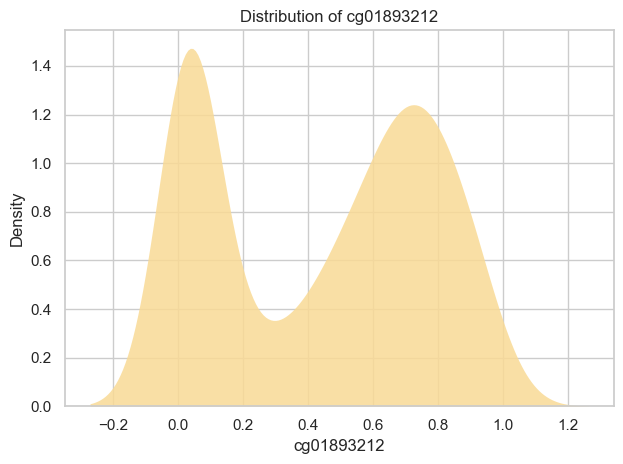

In [93]:
color = wes.Darjeeling2_5.mpl_colors[2]  # pick a color from the palette

cpg = data['DNAm']["expr"].columns[1]

sns.set(style="whitegrid")
sns.kdeplot(data=data['DNAm']["expr"], x=f"{cpg}", fill=True, color=color, alpha=0.85, linewidth=0)
plt.xlabel(f"{cpg}")
plt.ylabel("Density"); 
plt.title(f"Distribution of {cpg}")
plt.tight_layout()
plt.show()

## Proteomics (RPPA)

Proteomics studies all the proteins in a cell or tissue—what’s there and how much.

The proteomics dataset we are using is Reverse Phase Protein Array (RPPA). This dataset is a table of protein abundance levels across the tumour tissue samples.

It is measure by microscope technologies by tagging proteins in the samples with a chemical dye and quantifying how much of each protein is present by their illuminaiton. 

Proteomics is really useful to get an accurate pin-point snapshop of the biology of the tumour in its measured state. The downside is that protein measurements are sparse across patient samples with many missing samples as not every protein will be abundant in each patient. How you handle this artefact will be an important consideration in your analyses and could effect different models differently. 

In [94]:
data['RPPA']["expr"].head()

,1433BETA,1433EPSILON,1433ZETA,4EBP1,4EBP1_pS65,4EBP1_pT37T46,4EBP1_pT70,53BP1,ACC_pS79,ACC1,...,XPF,XRCC1,YAP,YAP_pS127,YB1,YB1_pS102,YTHDF2,YTHDF3,ZAP-70,ZEB1
TCGA-E9-A228,-0.011293,-0.060878,-0.202675,1.35820,0.020965,0.312617,0.102329,0.204165,0.604385,0.32035,...,0.231692,0.020158,-0.342985,-0.776035,0.057015,-0.340385,-0.099780,0.110625,-0.697522,0.226013
TCGA-HN-A2NL,0.252110,0.080503,0.197350,-0.29719,-0.374150,0.463070,-0.407030,-0.941850,0.765260,0.47086,...,0.579617,-0.424650,0.331740,0.371280,-0.220320,0.131920,-0.752445,-1.048190,0.480243,0.760178
TCGA-OL-A5D7,-0.014454,0.026866,-0.334580,0.67399,-0.605530,-0.491210,-0.009052,-0.384940,-0.186570,-0.56132,...,0.100363,0.100020,-0.020238,-0.605830,-0.676840,-0.154990,0.508370,-0.157935,2.031538,0.245044
TCGA-A2-A3KC,0.106510,0.241750,0.303230,-0.28122,-0.586760,-0.853800,-0.406400,-0.079820,0.155410,0.14472,...,-0.038458,0.101470,-0.074459,0.048927,-0.382870,-0.273140,-0.599380,-0.461275,0.632358,0.339843
TCGA-A2-A0YI,0.008400,0.101940,0.379810,-0.45383,-0.438570,-0.091300,-0.181230,0.489960,0.822000,0.58515,...,1.028037,0.167430,-0.351550,-0.286540,-0.432520,-0.194490,-0.290635,-0.340180,0.842933,0.077968


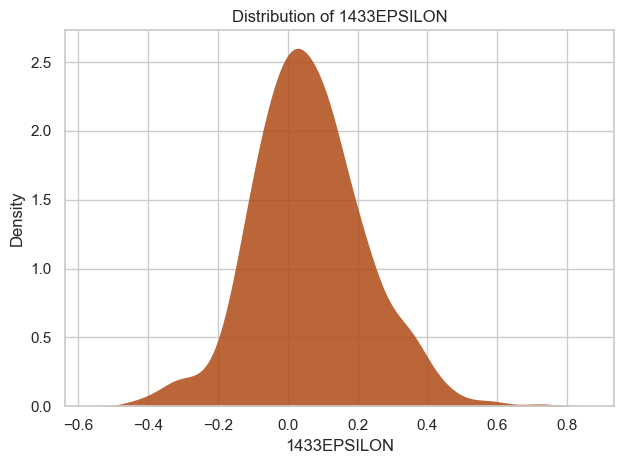

In [95]:
color = wes.Darjeeling2_5.mpl_colors[3]  # pick a color from the palette

prtn = data['RPPA']["expr"].columns[1]

sns.set(style="whitegrid")
sns.kdeplot(data=data['RPPA']["expr"], x=f"{prtn}", fill=True, color=color, alpha=0.85, linewidth=0)
plt.xlabel(f"{prtn}")
plt.ylabel("Density"); 
plt.title(f"Distribution of {prtn}")
plt.tight_layout()
plt.show()

## Next Steps 

1. Data Exploration Analysis (DEA)
   - How many patients are common to each omic, pairs of omics, and across all omics?
   - Missingness in each omic?
     - Methods of imputation?
   - Patient outliers?
     
2. MOFA

3. IntegrAO

4. PNet

# LOGREG

In [96]:
dnam_patients = data['DNAm']['meta']['patient']
mrna_patients = data['mRNA']['meta']['patient']
rppa_patients = data['RPPA']['meta']['patient']

set_dnam = set(dnam_patients)
set_mrna = set(mrna_patients)
set_rppa = set(rppa_patients)

intersection_dnam_mrna = set_dnam & set_mrna
intersection_mrna_rppa = set_mrna & set_rppa
intersection_dnam_rppa = set_dnam & set_rppa
intersection_all = set_dnam & set_mrna & set_rppa

print(f"Common patients between DNAm and mRNA: {len(intersection_dnam_mrna)}")
print(f"Common patients between mRNA and RPPA: {len(intersection_mrna_rppa)}")
print(f"Common patients between DNAm and RPPA: {len(intersection_dnam_rppa)}")
print(f"Common patients between all three: {len(intersection_all)}")

Common patients between DNAm and mRNA: 415
Common patients between mRNA and RPPA: 414
Common patients between DNAm and RPPA: 414
Common patients between all three: 401


In [97]:
idx_mrna = set(data["mRNA"]["expr"].index)
idx_meth = set(data["DNAm"]["expr"].index)
idx_prot = set(data["RPPA"]["expr"].index)
patients_intersection = sorted(list(idx_mrna & idx_meth & idx_prot))
print(f"Expr intersection size: {len(patients_intersection)}")

Expr intersection size: 401


In [98]:
def get_pam50(view_name):
    meta = data[view_name].get("meta", None)
    if meta is None or "paper_BRCA_Subtype_PAM50" not in meta.columns:
        return pd.Series(index=[], dtype="object")
    s = meta["paper_BRCA_Subtype_PAM50"].astype(str).str.strip()
    s = s.replace({"nan": np.nan, "None": np.nan, "": np.nan})
    s.name = view_name
    return s

In [99]:
pam_mrna = get_pam50("mRNA")
pam_meth = get_pam50("DNAm")
pam_prot = get_pam50("RPPA")
pam_df = pd.concat([pam_mrna, pam_meth, pam_prot], axis=1)
pam_df = pam_df.reindex(patients_intersection)

In [100]:
pam50 = pam_df.bfill(axis=1).iloc[:, 0]
conflict_mask = (pam_df.nunique(axis=1, dropna=True) > 1)
n_conflicts = int(conflict_mask.sum())
if n_conflicts:
    print(f"Warning: {n_conflicts} patients have conflicting PAM50 labels across metas (keeping mRNA>DNAm>RPPA).")
pam50 = pam50.dropna()
patients = pam50.index.tolist()
print(f"Patients with PAM50 on expr-intersection: {len(patients)}")

Patients with PAM50 on expr-intersection: 401


In [101]:
X_mrna = data["mRNA"]["expr"].loc[patients].values
X_meth = data["DNAm"]["expr"].loc[patients].values
X_prot = data["RPPA"]["expr"].loc[patients].values
y_str  = pam50.astype(str).values

In [102]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y_str)
class_names = list(le.classes_)
print("PAM50 classes:", class_names)
print(pd.Series(y_str).value_counts())

PAM50 classes: ['Basal', 'Her2', 'LumA', 'LumB']
LumA     230
LumB      82
Basal     61
Her2      28
Name: count, dtype: int64


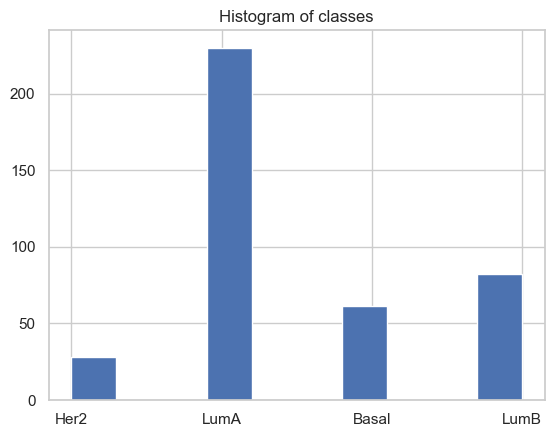

In [103]:
plt.figure()
plt.hist(y_str)
plt.title('Histogram of classes')
plt.show()

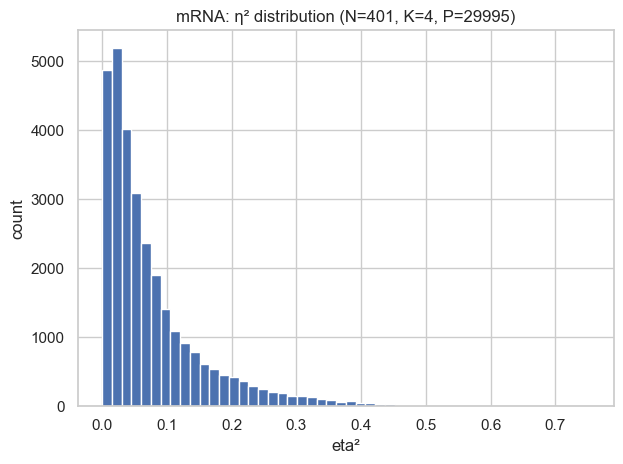

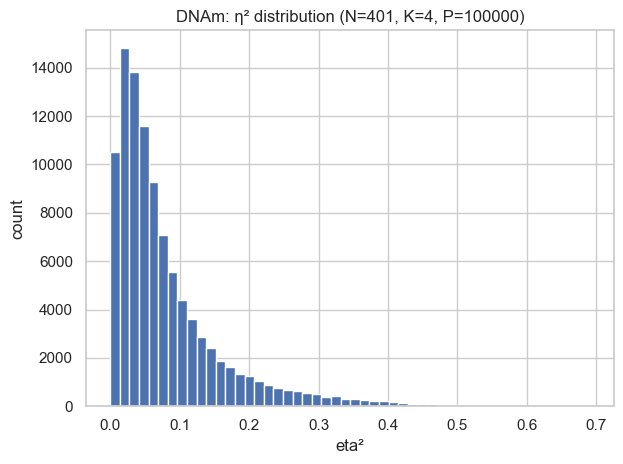

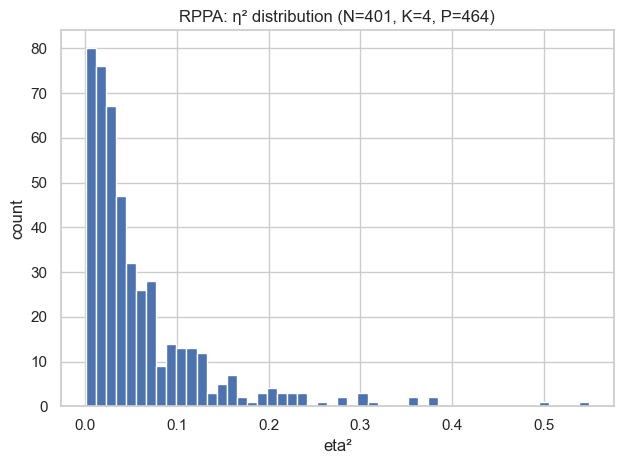

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif

def per_feature_anova_np(
    X: np.ndarray,               # shape (N, P)
    y: np.ndarray,               # shape (N,), integer classes
    view_name: str,              # e.g., "mRNA", "DNAm", "RPPA"
    topN: int = 30,              # for the bar plot
    topK_scatter: int = 3000,    # for volcano-like scatter
    save_prefix: str | None = None,
    feature_names: list[str] | None = None
):
    N, P = X.shape
    K = len(np.unique(y))
    if feature_names is None:
        width = len(str(P))
        feature_names = [f"{view_name.lower()}_{i:0{width}d}" for i in range(P)]

    # 1) ANOVA F and p across classes for every feature
    F, p = f_classif(X, y)  # vector length P
    F = np.nan_to_num(F, nan=0.0, posinf=0.0, neginf=0.0)
    p = np.nan_to_num(p, nan=1.0, posinf=1.0, neginf=1.0)

    # 2) Effect size η² (0..1)
    eta2 = ((K - 1) * F) / (((K - 1) * F) + (N - K) + 1e-12)

    # 3) Build table and save
    res = pd.DataFrame({
        "feature": feature_names,
        "F": F,
        "p": p,
        "eta2": eta2
    }).sort_values("eta2", ascending=False).reset_index(drop=True)
    res["rank"] = np.arange(1, P + 1)
    res["view"] = view_name

    
    # 4) Plots (compact summaries)
    # Histogram of eta^2
    plt.figure()
    plt.hist(res["eta2"].values, bins=50)
    plt.title(f"{view_name}: η² distribution (N={N}, K={K}, P={P})")
    plt.xlabel("eta²")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

    return res

# ==== Use on your NumPy arrays (aligned to the same patients as y) ====
mrna_scores = per_feature_anova_np(X_mrna, y, "mRNA",  topN=30, topK_scatter=3000, save_prefix="mRNA")
meth_scores = per_feature_anova_np(X_meth, y, "DNAm", topN=30, topK_scatter=3000, save_prefix="DNAm")
prot_scores = per_feature_anova_np(X_prot, y, "RPPA", topN=30, topK_scatter=3000, save_prefix="RPPA")


In [105]:
s = mrna_scores["eta2"].values
# Count how many exceed practical effect thresholds
for t in [0.05, 0.1, 0.2, 0.3]:
    print(f"eta² > {t}: {(s>t).sum()} features")

eta² > 0.05: 14800 features
eta² > 0.1: 7609 features
eta² > 0.2: 2623 features
eta² > 0.3: 878 features


In [106]:
s = meth_scores["eta2"].values
# Count how many exceed practical effect thresholds
for t in [0.05, 0.1, 0.2, 0.3]:
    print(f"eta² > {t}: {(s>t).sum()} features")

eta² > 0.05: 53450 features
eta² > 0.1: 26287 features
eta² > 0.2: 8699 features
eta² > 0.3: 3154 features


In [107]:
s = prot_scores["eta2"].values
# Count how many exceed practical effect thresholds
for t in [0.05, 0.1, 0.2, 0.3]:
    print(f"eta² > {t}: {(s>t).sum()} features")

eta² > 0.05: 175 features
eta² > 0.1: 85 features
eta² > 0.2: 25 features
eta² > 0.3: 10 features


In [108]:
from sklearn.model_selection import train_test_split

X_concat = np.hstack([X_mrna, X_meth, X_prot])
idx_all = np.arange(len(y))
idx_tr, idx_te = train_test_split(idx_all, test_size=0.2, stratify=y, random_state=42)

Xtr_c, Xte_c = X_concat[idx_tr], X_concat[idx_te]
Xtr_m, Xte_m = X_mrna[idx_tr],  X_mrna[idx_te]
Xtr_d, Xte_d = X_meth[idx_tr],  X_meth[idx_te]
Xtr_p, Xte_p = X_prot[idx_tr],  X_prot[idx_te]
y_tr, y_te = y[idx_tr], y[idx_te]

KeyboardInterrupt: 

### Early integration

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_auc_score

P1, P2, P3 = X_mrna.shape[1], X_meth.shape[1], X_prot.shape[1]
idx_mrna = list(range(0, P1))
idx_meth = list(range(P1, P1+P2))
idx_prot = list(range(P1+P2, P1+P2+P3))

def view_block(k=None):
    steps = [("scale", StandardScaler())]
    if k is not None:
        steps.append(("kbest", SelectKBest(f_classif, k=k)))
    return Pipeline(steps)
#K1, K2, K3 = 878,3154,10   # where eta2 > 0.3
K1, K2, K3 = 2623,8699,25   # where eta2 > 0.2

# we take relatively low k
K_MRNA, K_METH, K_PROT = min(K1, P1), min(K2, P2), min(K3, P3)

pre = ColumnTransformer(
    transformers=[
        ("mrna", view_block(K_MRNA), idx_mrna),
        ("meth", view_block(K_METH), idx_meth),
        ("prot", view_block(K_PROT), idx_prot),
    ],
    remainder="drop"
)

ef = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(
        penalty="l2",
        solver="saga",
        multi_class="multinomial",
        class_weight="balanced",
        max_iter=5000,
        n_jobs=-1,
        random_state=42
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {"clf__C": [0.01, 0.1, 1, 10, 100]}

gs_ef = GridSearchCV(
    ef, param_grid,
    scoring={"bal_acc":"balanced_accuracy", "logloss":"neg_log_loss", "auc":"roc_auc_ovr_weighted"},
    refit="bal_acc", cv=cv, n_jobs=-1, verbose = 2
)
gs_ef.fit(Xtr_c, y_tr)

print("EF best params:", gs_ef.best_params_)
y_pred = gs_ef.predict(Xte_c)
proba  = gs_ef.predict_proba(Xte_c)

print("Balanced Acc:", balanced_accuracy_score(y_te, y_pred).round(3))
print("ROC-AUC (OvR, weighted):", roc_auc_score(y_te, proba, multi_class="ovr", average="weighted").round(3))
print(classification_report(y_te, y_pred, digits=3)) 
print("Confusion matrix:\n", confusion_matrix(y_te, y_pred))


Fitting 5 folds for each of 5 candidates, totalling 25 fits


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: F

[CV] END ........................................clf__C=0.01; total time=  24.7s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ........................................clf__C=0.01; total time=  26.4s
[CV] END ........................................clf__C=0.01; total time=  26.6s
[CV] END ........................................clf__C=0.01; total time=  27.0s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ........................................clf__C=0.01; total time=  33.6s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .........................................clf__C=0.1; total time=  48.8s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .........................................clf__C=0.1; total time=  51.4s
[CV] END .........................................clf__C=0.1; total time=  51.8s
[CV] END .........................................clf__C=0.1; total time=  52.7s
[CV] END .........................................clf__C=0.1; total time=  53.3s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: F

[CV] END ...........................................clf__C=1; total time= 1.2min
[CV] END ...........................................clf__C=1; total time= 1.2min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ...........................................clf__C=1; total time= 1.2min
[CV] END ...........................................clf__C=1; total time= 1.1min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ...........................................clf__C=1; total time= 1.2min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..........................................clf__C=10; total time= 1.2min
[CV] END ..........................................clf__C=10; total time= 1.3min
[CV] END ..........................................clf__C=10; total time= 1.3min
[CV] END ..........................................clf__C=10; total time= 1.3min
[CV] END ..........................................clf__C=10; total time= 1.3min
[CV] END .........................................clf__C=100; total time= 1.1min
[CV] END .........................................clf__C=100; total time= 1.1min
[CV] END .........................................clf__C=100; total time=  59.8s
[CV] END .........................................clf__C=100; total time= 1.0min
[CV] END .........................................clf__C=100; total time= 1.1min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


EF best params: {'clf__C': 0.01}
Balanced Acc: 0.823
ROC-AUC (OvR, weighted): 0.94
              precision    recall  f1-score   support

           0      0.923     1.000     0.960        12
           1      0.833     0.833     0.833         6
           2      0.851     0.870     0.860        46
           3      0.667     0.588     0.625        17

    accuracy                          0.827        81
   macro avg      0.819     0.823     0.820        81
weighted avg      0.822     0.827     0.824        81

Confusion matrix:
 [[12  0  0  0]
 [ 0  5  0  1]
 [ 1  1 40  4]
 [ 0  0  7 10]]


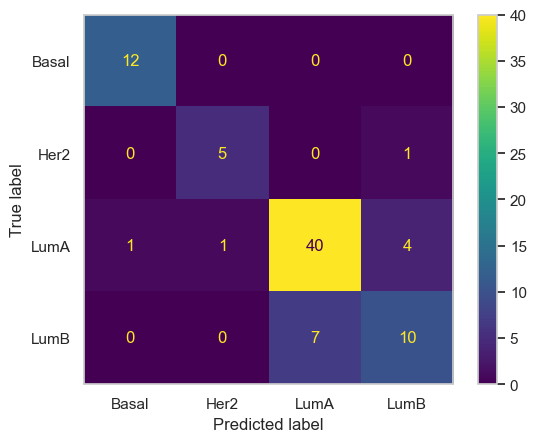

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
classes = np.unique(y_str)
cm = confusion_matrix(y_te, y_pred)

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(ax=ax, cmap="viridis", colorbar=True)
ax.grid(False) 
plt.show()

### Dodata l1 reg --> sve do late integration

In [ ]:
# --- 1. Define per-view feature indices ---
P1, P2, P3 = X_mrna.shape[1], X_meth.shape[1], X_prot.shape[1]
idx_mrna = list(range(0, P1))
idx_meth = list(range(P1, P1+P2))
idx_prot = list(range(P1+P2, P1+P2+P3))

# --- 2. Define K per view (from eta² or based on domain knowledge) ---
K_MRNA, K_METH, K_PROT = 878, 3154, 10  # adjust as you like

# --- 3. Define preprocessing per view ---
def view_block_anova(k):
    return Pipeline([
        ("scale", StandardScaler()),
        ("anova", SelectKBest(f_classif, k=k))
    ])

pre = ColumnTransformer(transformers=[
    ("mrna", view_block_anova(K_MRNA), idx_mrna),
    ("meth", view_block_anova(K_METH), idx_meth),
    ("prot", view_block_anova(K_PROT), idx_prot),
])

# --- 4. Define final classifier (L1 for sparsity & interpretability) ---
clf = LogisticRegression(
    penalty="l1",
    solver="saga",             # supports L1 + multinomial
    multi_class="multinomial",
    class_weight="balanced",
    max_iter=5000,
    n_jobs=-1,
    random_state=42
)

# --- 5. Combine into pipeline ---
anova_l1_pipe = Pipeline([
    ("pre", pre),
    ("clf", clf)
])

# --- 6. Define CV and hyperparameter grid ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {"clf__C": [0.01, 0.1, 1, 10, 100]}  # regularization strength

# --- 7. Grid search training ---
gs_anova_l1 = GridSearchCV(
    anova_l1_pipe,
    param_grid,
    scoring={
        "bal_acc": "balanced_accuracy",
        "logloss": "neg_log_loss",
        "auc": "roc_auc_ovr_weighted"
    },
    refit="bal_acc",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

gs_anova_l1.fit(Xtr_c, y_tr)

# --- 8. Evaluation ---
print("ANOVA + L1 best params:", gs_anova_l1.best_params_)
y_pred = gs_anova_l1.predict(Xte_c)
proba  = gs_anova_l1.predict_proba(Xte_c)

print("Balanced Acc:", balanced_accuracy_score(y_te, y_pred).round(3))
print("ROC-AUC (OvR, weighted):", roc_auc_score(y_te, proba, multi_class="ovr", average="weighted").round(3))
print(classification_report(y_te, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_te, y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: F

[CV] END ........................................clf__C=0.01; total time=  18.6s
[CV] END ........................................clf__C=0.01; total time=  19.4s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ........................................clf__C=0.01; total time=  21.9s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ........................................clf__C=0.01; total time=  36.0s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ........................................clf__C=0.01; total time=  39.9s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .........................................clf__C=0.1; total time=  57.0s
[CV] END .........................................clf__C=0.1; total time=  57.1s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .........................................clf__C=0.1; total time= 1.1min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .........................................clf__C=0.1; total time= 1.4min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .........................................clf__C=0.1; total time= 1.5min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ...........................................clf__C=1; total time= 1.4min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...........................................clf__C=1; total time= 1.6min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ...........................................clf__C=1; total time= 1.6min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...........................................clf__C=1; total time= 1.6min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ...........................................clf__C=1; total time= 1.6min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..........................................clf__C=10; total time= 1.6min
[CV] END ..........................................clf__C=10; total time= 1.6min
[CV] END .........................................clf__C=100; total time=  55.2s
[CV] END ..........................................clf__C=10; total time= 1.6min
[CV] END .........................................clf__C=100; total time=  56.8s
[CV] END .........................................clf__C=100; total time=  56.2s
[CV] END ..........................................clf__C=10; total time= 1.5min
[CV] END .........................................clf__C=100; total time=  47.7s
[CV] END .........................................clf__C=100; total time=  46.0s
[CV] END ..........................................clf__C=10; total time= 1.6min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


ANOVA + L1 best params: {'clf__C': 1}
Balanced Acc: 0.848
ROC-AUC (OvR, weighted): 0.94
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        12
           1      0.833     0.833     0.833         6
           2      0.894     0.913     0.903        46
           3      0.688     0.647     0.667        17

    accuracy                          0.864        81
   macro avg      0.854     0.848     0.851        81
weighted avg      0.862     0.864     0.863        81

Confusion matrix:
 [[12  0  0  0]
 [ 0  5  0  1]
 [ 0  0 42  4]
 [ 0  1  5 11]]


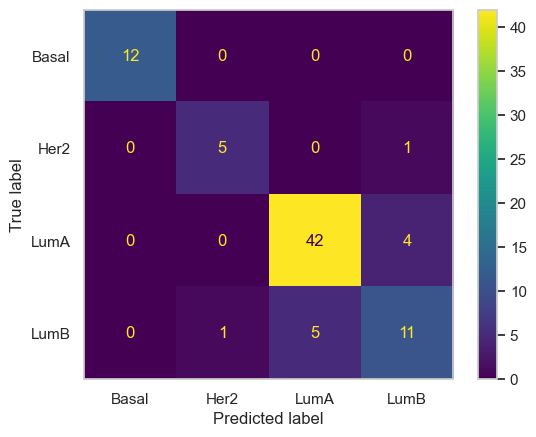

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
classes = np.unique(y_str)
cm = confusion_matrix(y_te, y_pred)

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(ax=ax, cmap="viridis", colorbar=True)
ax.grid(False) 
plt.show()

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# --- compute balanced class weights ---
classes = np.unique(y_tr)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr)
cw = dict(zip(classes, weights))

# --- boost LumA (2) and LumB (3) ---
cw[2] *= 1.2
cw[3] *= 1.2

print("Adjusted class weights:", cw)


Adjusted class weights: {0: 1.6326530612244898, 1: 3.6363636363636362, 2: 0.5217391304347826, 3: 1.476923076923077}


In [ ]:
# --- 1. Define per-view feature indices ---
P1, P2, P3 = X_mrna.shape[1], X_meth.shape[1], X_prot.shape[1]
idx_mrna = list(range(0, P1))
idx_meth = list(range(P1, P1+P2))
idx_prot = list(range(P1+P2, P1+P2+P3))

# --- 2. Define K per view (from eta² or based on domain knowledge) ---
K_MRNA, K_METH, K_PROT = 878, 3154, 10  # adjust as you like

# --- 3. Define preprocessing per view ---
def view_block_anova(k):
    return Pipeline([
        ("scale", StandardScaler()),
        ("anova", SelectKBest(f_classif, k=k))
    ])

pre = ColumnTransformer(transformers=[
    ("mrna", view_block_anova(K_MRNA), idx_mrna),
    ("meth", view_block_anova(K_METH), idx_meth),
    ("prot", view_block_anova(K_PROT), idx_prot),
])

clf = LogisticRegression(
    solver="saga",
    multi_class="multinomial",
    class_weight=cw,          # custom dictionary
    max_iter=5000,
    n_jobs=-1,
    random_state=42
)

# --- 5. Combine into pipeline ---
anova_l1_pipe = Pipeline([
    ("pre", pre),
    ("clf", clf)
])

# --- 6. Define CV and hyperparameter grid ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {"clf__C": [0.01, 0.1, 1, 10, 100],
              "clf__penalty": ['l1', 'l2'],
              'clf__class_weight': [
                None,  # no weighting
                'balanced',  # automatic weighting
                {0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5},
                {0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8},  # manually overweight class 0
            ],}  # regularization strength

# --- 7. Grid search training ---
gs_anova_l1 = GridSearchCV(
    anova_l1_pipe,
    param_grid,
    scoring={
        "bal_acc": "balanced_accuracy",
        "logloss": "neg_log_loss",
        "auc": "roc_auc_ovr_weighted"
    },
    refit="bal_acc",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

gs_anova_l1.fit(Xtr_c, y_tr)

# --- 8. Evaluation ---
print("ANOVA + L1 best params:", gs_anova_l1.best_params_)
y_pred = gs_anova_l1.predict(Xte_c)
proba  = gs_anova_l1.predict_proba(Xte_c)

print("Balanced Acc:", balanced_accuracy_score(y_te, y_pred).round(3))
print("ROC-AUC (OvR, weighted):", roc_auc_score(y_te, proba, multi_class="ovr", average="weighted").round(3))
print(classification_report(y_te, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_te, y_pred))


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: F

[CV] END clf__C=0.01, clf__class_weight=None, clf__penalty=l1; total time=   7.3s
[CV] END clf__C=0.01, clf__class_weight=None, clf__penalty=l1; total time=   7.4s
[CV] END clf__C=0.01, clf__class_weight=None, clf__penalty=l1; total time=   7.5s
[CV] END clf__C=0.01, clf__class_weight=None, clf__penalty=l1; total time=   7.6s
[CV] END clf__C=0.01, clf__class_weight=None, clf__penalty=l1; total time=   7.6s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: F

[CV] END clf__C=0.01, clf__class_weight=None, clf__penalty=l2; total time=  11.8s
[CV] END clf__C=0.01, clf__class_weight=None, clf__penalty=l2; total time=  11.9s
[CV] END clf__C=0.01, clf__class_weight=None, clf__penalty=l2; total time=  12.5s
[CV] END clf__C=0.01, clf__class_weight=None, clf__penalty=l2; total time=  12.5s
[CV] END clf__C=0.01, clf__class_weight=None, clf__penalty=l2; total time=  12.5s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: F

[CV] END clf__C=0.01, clf__class_weight=balanced, clf__penalty=l2; total time=   5.7s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__penalty=l2; total time=   6.3s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.01, clf__class_weight=balanced, clf__penalty=l2; total time=   6.0s
[CV] END clf__C=0.01, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time=   1.3s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__penalty=l2; total time=   6.3s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END clf__C=0.01, clf__class_weight=balanced, clf__penalty=l2; total time=   6.5s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.01, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time=   1.4s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.01, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time=   1.6s
[CV] END clf__C=0.01, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time=   1.6s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.01, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time=   1.8s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.01, clf__class_weight=balanced, clf__penalty=l1; total time=  15.8s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__penalty=l1; total time=  15.9s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.01, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time=   1.6s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__penalty=l1; total time=  18.5s
[CV] END clf__C=0.01, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=   5.6s
[CV] END clf__C=0.01, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=   5.8s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.01, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=   5.6s
[CV] END clf__C=0.01, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=   5.7s
[CV] END clf__C=0.01, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=   5.4s
[CV] END clf__C=0.01, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time=   2.1s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: F

[CV] END clf__C=0.01, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=   5.1s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.01, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=   5.6s
[CV] END clf__C=0.01, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=   5.0s
[CV] END clf__C=0.01, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=   5.5s
[CV] END clf__C=0.01, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=   5.5s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: F

[CV] END clf__C=0.01, clf__class_weight=balanced, clf__penalty=l1; total time=  32.7s
[CV] END clf__C=0.01, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time=  14.0s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.01, clf__class_weight=balanced, clf__penalty=l1; total time=  35.9s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.01, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time=  23.5s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight=None, clf__penalty=l2; total time=  11.5s
[CV] END clf__C=0.1, clf__class_weight=None, clf__penalty=l2; total time=  12.0s
[CV] END clf__C=0.01, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time=  27.1s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight=None, clf__penalty=l2; total time=  12.7s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight=None, clf__penalty=l2; total time=  12.5s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight=None, clf__penalty=l2; total time=  12.8s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight=None, clf__penalty=l1; total time=  57.4s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight=None, clf__penalty=l1; total time= 1.0min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight=None, clf__penalty=l1; total time= 1.1min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l2; total time=  13.1s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l1; total time=  50.9s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l2; total time=  13.6s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight=None, clf__penalty=l1; total time= 1.3min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l1; total time=  51.7s
[CV] END clf__C=0.1, clf__class_weight=None, clf__penalty=l1; total time= 1.3min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l1; total time=  59.0s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l2; total time=  14.0s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l2; total time=  13.5s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l2; total time=  13.7s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=  10.9s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=  11.2s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=  12.3s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l1; total time= 1.3min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=  11.4s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=  12.7s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l1; total time= 1.3min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time=  58.1s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time=  58.9s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time= 1.1min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=  10.6s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=  11.0s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time= 1.3min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time= 1.2min
[CV] END clf__C=0.1, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=  12.0s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=  11.5s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=  11.9s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time= 1.0min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time= 1.1min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time= 1.0min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time= 1.3min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time= 1.3min
[CV] END ..clf__C=1, clf__class_weight=None, clf__penalty=l2; total time=  20.9s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..clf__C=1, clf__class_weight=None, clf__penalty=l2; total time=  22.8s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..clf__C=1, clf__class_weight=None, clf__penalty=l2; total time=  22.8s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..clf__C=1, clf__class_weight=None, clf__penalty=l2; total time=  22.6s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..clf__C=1, clf__class_weight=None, clf__penalty=l2; total time=  23.9s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..clf__C=1, clf__class_weight=None, clf__penalty=l1; total time= 1.3min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..clf__C=1, clf__class_weight=None, clf__penalty=l1; total time= 1.5min
[CV] END ..clf__C=1, clf__class_weight=None, clf__penalty=l1; total time= 1.4min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..clf__C=1, clf__class_weight=None, clf__penalty=l1; total time= 1.5min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..clf__C=1, clf__class_weight=None, clf__penalty=l1; total time= 1.5min
[CV] END clf__C=1, clf__class_weight=balanced, clf__penalty=l2; total time=  22.2s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=1, clf__class_weight=balanced, clf__penalty=l2; total time=  24.5s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=1, clf__class_weight=balanced, clf__penalty=l2; total time=  24.8s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=1, clf__class_weight=balanced, clf__penalty=l2; total time=  24.2s
[CV] END clf__C=1, clf__class_weight=balanced, clf__penalty=l1; total time= 1.4min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=1, clf__class_weight=balanced, clf__penalty=l2; total time=  22.9s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__class_weight=balanced, clf__penalty=l1; total time= 1.5min
[CV] END clf__C=1, clf__class_weight=balanced, clf__penalty=l1; total time= 1.5min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__class_weight=balanced, clf__penalty=l1; total time= 1.5min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=1, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=  19.9s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__class_weight=balanced, clf__penalty=l1; total time= 1.5min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=1, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=  22.1s
[CV] END clf__C=1, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=  22.7s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=1, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=  21.6s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=1, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=  23.1s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=1, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time= 1.5min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=1, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time= 1.3min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=1, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time= 1.4min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time= 1.5min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=1, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time= 1.5min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=1, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=  21.3s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=1, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=  22.9s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=1, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=  23.5s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=1, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=  22.7s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=1, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=  24.4s
[CV] END clf__C=1, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time= 1.4min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=1, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time= 1.6min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time= 1.6min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=1, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time= 1.5min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=1, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time= 1.6min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .clf__C=10, clf__class_weight=None, clf__penalty=l2; total time=  27.1s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .clf__C=10, clf__class_weight=None, clf__penalty=l2; total time=  28.5s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .clf__C=10, clf__class_weight=None, clf__penalty=l2; total time=  29.4s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .clf__C=10, clf__class_weight=None, clf__penalty=l2; total time=  28.2s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .clf__C=10, clf__class_weight=None, clf__penalty=l2; total time=  29.4s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .clf__C=10, clf__class_weight=None, clf__penalty=l1; total time= 1.4min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .clf__C=10, clf__class_weight=None, clf__penalty=l1; total time= 1.5min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .clf__C=10, clf__class_weight=None, clf__penalty=l1; total time= 1.6min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .clf__C=10, clf__class_weight=None, clf__penalty=l1; total time= 1.6min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight=balanced, clf__penalty=l2; total time=  27.9s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight=balanced, clf__penalty=l2; total time=  30.4s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .clf__C=10, clf__class_weight=None, clf__penalty=l1; total time= 1.8min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight=balanced, clf__penalty=l2; total time=  31.0s
[CV] END clf__C=10, clf__class_weight=balanced, clf__penalty=l2; total time=  29.5s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight=balanced, clf__penalty=l2; total time=  29.5s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight=balanced, clf__penalty=l1; total time= 1.6min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight=balanced, clf__penalty=l1; total time= 1.6min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight=balanced, clf__penalty=l1; total time= 1.6min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight=balanced, clf__penalty=l1; total time= 1.6min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=  25.7s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=  26.9s
[CV] END clf__C=10, clf__class_weight=balanced, clf__penalty=l1; total time= 1.7min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=  28.2s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=  26.5s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=  27.7s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time= 1.4min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time= 1.4min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time= 1.5min
[CV] END clf__C=10, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=  26.0s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time= 1.5min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=  28.5s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time= 1.7min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=  28.2s
[CV] END clf__C=10, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=  30.0s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=  28.7s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time= 1.4min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time= 1.5min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time= 1.6min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time= 1.6min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight=None, clf__penalty=l2; total time=  27.8s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight=None, clf__penalty=l1; total time=  53.5s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight=None, clf__penalty=l2; total time=  28.7s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time= 1.7min
[CV] END clf__C=100, clf__class_weight=None, clf__penalty=l1; total time=  57.8s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight=None, clf__penalty=l2; total time=  28.3s
[CV] END clf__C=100, clf__class_weight=None, clf__penalty=l2; total time=  30.8s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight=None, clf__penalty=l1; total time=  56.4s
[CV] END clf__C=100, clf__class_weight=None, clf__penalty=l1; total time=  57.9s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight=None, clf__penalty=l1; total time=  59.3s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight=None, clf__penalty=l2; total time=  30.3s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight=balanced, clf__penalty=l2; total time=  29.0s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight=balanced, clf__penalty=l2; total time=  30.4s
[CV] END clf__C=100, clf__class_weight=balanced, clf__penalty=l2; total time=  31.3s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight=balanced, clf__penalty=l1; total time=  55.9s
[CV] END clf__C=100, clf__class_weight=balanced, clf__penalty=l2; total time=  29.7s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight=balanced, clf__penalty=l2; total time=  30.2s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight=balanced, clf__penalty=l1; total time= 1.0min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight=balanced, clf__penalty=l1; total time=  59.2s
[CV] END clf__C=100, clf__class_weight=balanced, clf__penalty=l1; total time= 1.0min


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight=balanced, clf__penalty=l1; total time=  59.0s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=  25.9s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=  27.3s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=  27.1s
[CV] END clf__C=100, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=  28.0s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time=  50.9s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l2; total time=  28.1s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time=  54.0s
[CV] END clf__C=100, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time=  55.0s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time=  53.6s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight={0: 1.0, 1: 1.2, 2: 1.1, 3: 1.5}, clf__penalty=l1; total time=  55.6s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END clf__C=100, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=  25.8s
[CV] END clf__C=100, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time=  50.2s
[CV] END clf__C=100, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=  27.5s
[CV] END clf__C=100, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=  26.5s
[CV] END clf__C=100, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=  27.8s
[CV] END clf__C=100, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l2; total time=  26.3s
[CV] END clf__C=100, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time=  50.0s
[CV] END clf__C=100, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time=  47.3s
[CV] END clf__C=100, clf__class_weight={0: 1.0, 1: 1.0, 2: 1.2, 3: 1.8}, clf__penalty=l1; total time=  48.5s
[CV] END clf__C=100

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


ANOVA + L1 best params: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1'}
Balanced Acc: 0.848
ROC-AUC (OvR, weighted): 0.94
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        12
           1      0.833     0.833     0.833         6
           2      0.894     0.913     0.903        46
           3      0.688     0.647     0.667        17

    accuracy                          0.864        81
   macro avg      0.854     0.848     0.851        81
weighted avg      0.862     0.864     0.863        81

Confusion matrix:
 [[12  0  0  0]
 [ 0  5  0  1]
 [ 0  0 42  4]
 [ 0  1  5 11]]


In [112]:
# --- 1. Define per-view feature indices ---
P1, P2, P3 = X_mrna.shape[1], X_meth.shape[1], X_prot.shape[1]
idx_mrna = list(range(0, P1))
idx_meth = list(range(P1, P1+P2))
idx_prot = list(range(P1+P2, P1+P2+P3))

# --- 2. Define K per view (from eta² or based on domain knowledge) ---
K_MRNA, K_METH, K_PROT = 878, 3154, 10  # adjust as you like

# --- 3. Define preprocessing per view ---
def view_block_anova(k):
    return Pipeline([
        ("scale", StandardScaler()),
        ("anova", SelectKBest(f_classif, k=k))
    ])

pre = ColumnTransformer(transformers=[
    ("mrna", view_block_anova(K_MRNA), idx_mrna),
    ("meth", view_block_anova(K_METH), idx_meth),
    ("prot", view_block_anova(K_PROT), idx_prot),
])

clf = LogisticRegression(
    solver="saga",
    multi_class="multinomial",
    class_weight='balanced',          # custom dictionary
    max_iter=5000,
    n_jobs=-1,
    random_state=42,
    penalty="l1",
    C=1.0,
)

# --- 5. Combine into pipeline ---
anova_l1_pipe = Pipeline([
    ("pre", pre),
    ("clf", clf)
])


anova_l1_pipe.fit(Xtr_c, y_tr)

# --- 8. Evaluation ---
y_pred = anova_l1_pipe.predict(Xte_c)
proba  = anova_l1_pipe.predict_proba(Xte_c)

print("Balanced Acc:", balanced_accuracy_score(y_te, y_pred).round(3))
print("ROC-AUC (OvR, weighted):", roc_auc_score(y_te, proba, multi_class="ovr", average="weighted").round(3))
print(classification_report(y_te, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_te, y_pred))


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Balanced Acc: 0.848
ROC-AUC (OvR, weighted): 0.94
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        12
           1      0.833     0.833     0.833         6
           2      0.894     0.913     0.903        46
           3      0.688     0.647     0.667        17

    accuracy                          0.864        81
   macro avg      0.854     0.848     0.851        81
weighted avg      0.862     0.864     0.863        81

Confusion matrix:
 [[12  0  0  0]
 [ 0  5  0  1]
 [ 0  0 42  4]
 [ 0  1  5 11]]


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


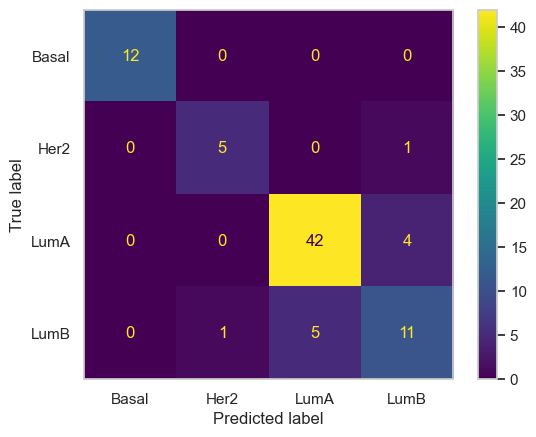

In [113]:
classes = np.unique(y_str)
cm = confusion_matrix(y_te, y_pred)

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(ax=ax, cmap="viridis", colorbar=True)
ax.grid(False) 
plt.show()

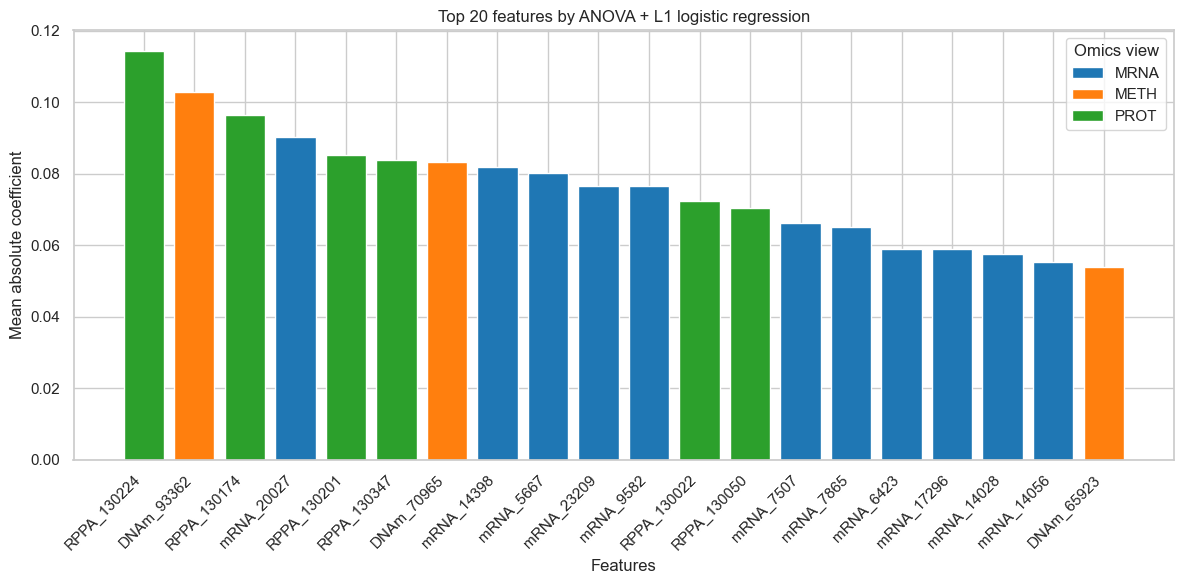

Top 20 selected features:
RPPA_130224          | weight=0.1144
DNAm_93362           | weight=0.1030
RPPA_130174          | weight=0.0963
mRNA_20027           | weight=0.0902
RPPA_130201          | weight=0.0853
RPPA_130347          | weight=0.0837
DNAm_70965           | weight=0.0834
mRNA_14398           | weight=0.0818
mRNA_5667            | weight=0.0801
mRNA_23209           | weight=0.0765
mRNA_9582            | weight=0.0764
RPPA_130022          | weight=0.0724
RPPA_130050          | weight=0.0703
mRNA_7507            | weight=0.0663
mRNA_7865            | weight=0.0649
mRNA_6423            | weight=0.0590
mRNA_17296           | weight=0.0589
mRNA_14028           | weight=0.0576
mRNA_14056           | weight=0.0553
DNAm_65923           | weight=0.0539


In [ ]:
from matplotlib.patches import Patch

# --- 1. Extract selected feature names and coefficients (same as before) ---
best_model = gs_anova_l1.best_estimator_
pre = best_model.named_steps["pre"]
clf = best_model.named_steps["clf"]

feat_names = []
feat_views = []
for name, transformer, cols in pre.transformers_:
    if name == "mrna":
        fn = [f"mRNA_{i}" for i in cols]
    elif name == "meth":
        fn = [f"DNAm_{i}" for i in cols]
    else:
        fn = [f"RPPA_{i}" for i in cols]
    selected_idx = transformer.named_steps["anova"].get_support(indices=True)
    fn = [fn[i] for i in selected_idx]
    feat_names.extend(fn)
    feat_views.extend([name]*len(fn))

coefs = clf.coef_
feat_importance = np.mean(np.abs(coefs), axis=0)

nonzero_mask = feat_importance != 0
feat_names = np.array(feat_names)[nonzero_mask]
feat_views = np.array(feat_views)[nonzero_mask]
feat_importance = feat_importance[nonzero_mask]

# --- 2. Select top N features ---
topN = 20
top_idx = np.argsort(feat_importance)[-topN:][::-1]
top_features = feat_names[top_idx]
top_importance = feat_importance[top_idx]
top_views = feat_views[top_idx]

# --- 3. Color mapping ---
color_map = {"mrna":"#1f77b4", "meth":"#ff7f0e", "prot":"#2ca02c"}
colors = [color_map[v] for v in top_views]

# --- 4. Vertical bar plot ---
plt.figure(figsize=(12,6))
bars = plt.bar(range(topN), top_importance, color=colors)
plt.xticks(range(topN), top_features, rotation=45, ha="right")
plt.ylabel("Mean absolute coefficient")
plt.xlabel("Features")
plt.title(f"Top {topN} features by ANOVA + L1 logistic regression")

# Add legend for omics view
legend_elements = [Patch(facecolor=color_map[v], label=v.upper()) for v in color_map]
plt.legend(handles=legend_elements, title="Omics view")

plt.tight_layout()
plt.show()

print("Top 20 selected features:")
for f, w in zip(top_features, top_importance):
    print(f"{f:20s} | weight={w:.4f}")


In [ ]:
best_model = gs_anova_l1.best_estimator_  # your fitted pipeline
pre = best_model.named_steps["pre"]       # ColumnTransformer
clf = best_model.named_steps["clf"]       # L1 logistic regression

# store counts
feature_counts = {}

for name, transformer, cols in pre.transformers_:
    # Get feature names for this view
    if name == "mrna":
        view_names = [f"mRNA_{i}" for i in cols]
    elif name == "meth":
        view_names = [f"DNAm_{i}" for i in cols]
    else:
        view_names = [f"RPPA_{i}" for i in cols]

    # Check ANOVA support
    anova_mask = transformer.named_steps["anova"].get_support()  # boolean array
    view_names = np.array(view_names)[anova_mask]

    # After ANOVA, check which features survived L1
    if hasattr(transformer, "named_steps") and "sel_l1" in transformer.named_steps:
        sel_mask = transformer.named_steps["sel_l1"].get_support()  # boolean mask after L1
        view_names = view_names[sel_mask]

    # Save count
    feature_counts[name] = len(view_names)

# total features
total_features = sum(feature_counts.values())

print("Number of features used per view:")
for v, c in feature_counts.items():
    print(f"  {v}: {c}")
print(f"Total features used in classification: {total_features}")


Number of features used per view:
  mrna: 878
  meth: 3154
  prot: 10
Total features used in classification: 4042


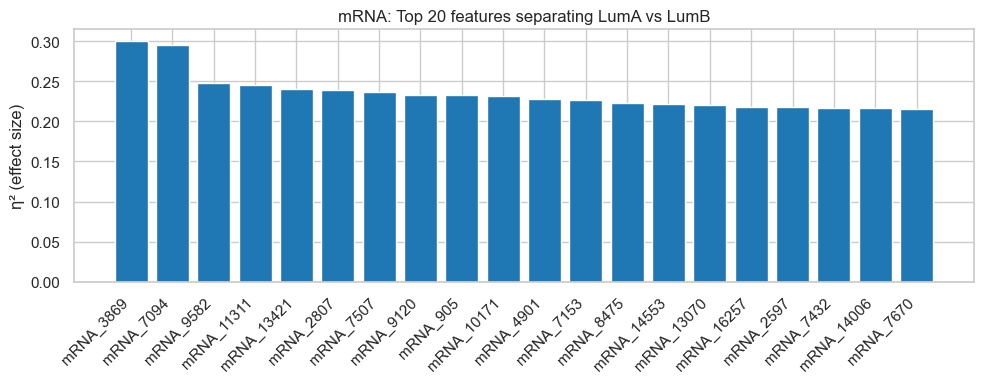

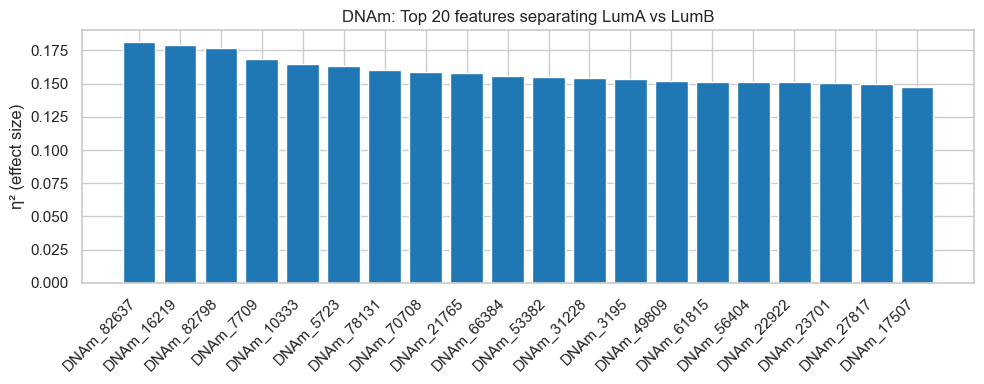

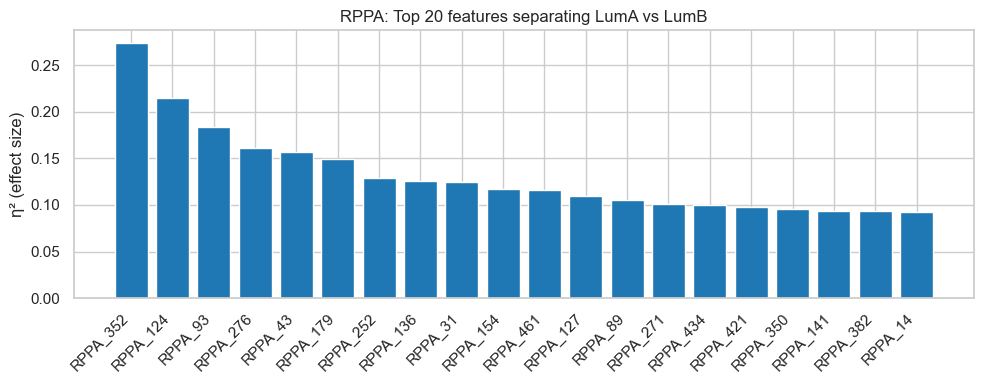

Top LumA/LumB mRNA features:
       feature           F             p      eta2
0   mRNA_3869  132.541678  8.967629e-26  0.299501
1   mRNA_7094  129.458295  2.672115e-25  0.294586
2   mRNA_9582  101.788239  6.947972e-21  0.247186
3  mRNA_11311  100.474156  1.145754e-20  0.244776
4  mRNA_13421   98.351743  2.579176e-20  0.240851
5   mRNA_2807   97.469920  3.617868e-20  0.239208
6   mRNA_7507   96.047743  6.254363e-20  0.236543
7   mRNA_9120   93.987179  1.387296e-19  0.232649
8    mRNA_905   93.973450  1.394699e-19  0.232623
9  mRNA_10171   93.332566  1.788420e-19  0.231403
Top LumA/LumB DNAm features:
       feature          F             p      eta2
0  DNAm_82637  68.519748  3.787025e-15  0.181020
1  DNAm_16219  67.776867  5.157241e-15  0.179410
2  DNAm_82798  66.500887  8.779023e-15  0.176629
3   DNAm_7709  62.977213  3.853562e-14  0.168850
4  DNAm_10333  61.024093  8.806204e-14  0.164475
5   DNAm_5723  60.453006  1.122347e-13  0.163187
6  DNAm_78131  59.205931  1.908853e-13  0.16036

In [ ]:
import seaborn as sns

def per_feature_anova_binary(
    X, y, view_name, topN=20, feature_names=None
):
    """Run ANOVA for LumA vs LumB within one omics view."""
    class_names = ["Basal", "Her2", "LumA", "LumB"]
    y_str = np.array([class_names[i] for i in y])
    mask = np.isin(y_str, ["LumA", "LumB"])
    X_sub, y_sub = X[mask], y_str[mask]

    N, P = X_sub.shape
    if feature_names is None:
        feature_names = [f"{view_name}_{i}" for i in range(P)]

    F, p = f_classif(X_sub, y_sub)
    F = np.nan_to_num(F, nan=0.0)
    p = np.nan_to_num(p, nan=1.0)

    eta2 = ((2 - 1) * F) / (((2 - 1) * F) + (N - 2) + 1e-12)

    res = pd.DataFrame({
        "feature": feature_names,
        "F": F,
        "p": p,
        "eta2": eta2
    }).sort_values("eta2", ascending=False).reset_index(drop=True)

    # --- Plot ---
    plt.figure(figsize=(10,4))
    top = res.head(topN)
    plt.bar(range(topN), top["eta2"], color="#1f77b4")
    plt.xticks(range(topN), top["feature"], rotation=45, ha="right")
    plt.ylabel("η² (effect size)")
    plt.title(f"{view_name}: Top {topN} features separating LumA vs LumB")
    plt.tight_layout()
    plt.show()

    return res

# --- Run per view ---
mrna_features = per_feature_anova_binary(X_mrna, y, "mRNA")
meth_features = per_feature_anova_binary(X_meth, y, "DNAm")
prot_features = per_feature_anova_binary(X_prot, y, "RPPA")

# --- View top features ---
print("Top LumA/LumB mRNA features:\n", mrna_features.head(10))
print("Top LumA/LumB DNAm features:\n", meth_features.head(10))
print("Top LumA/LumB RPPA features:\n", prot_features.head(10))


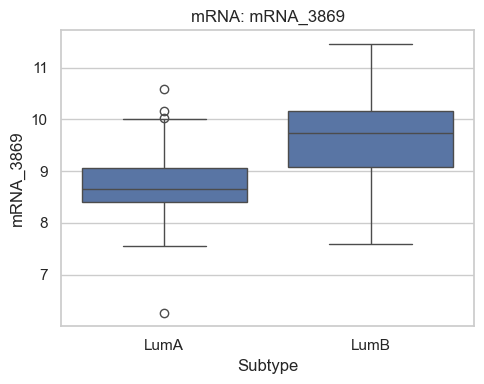

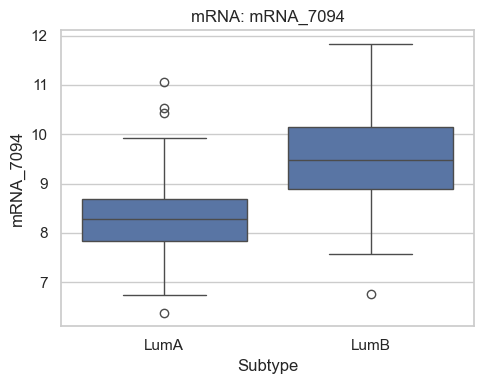

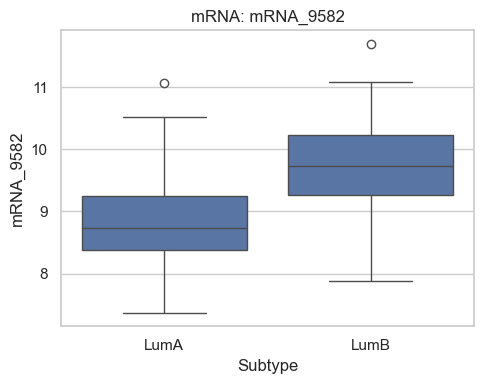

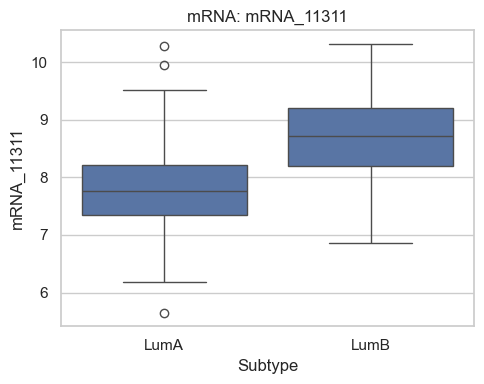

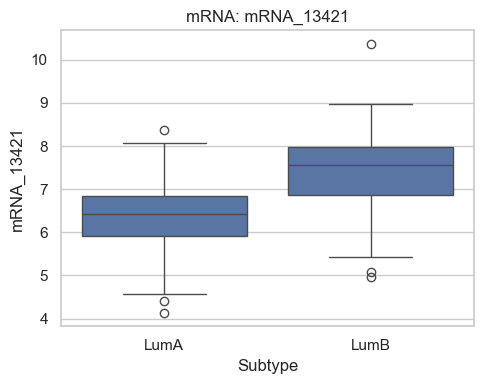

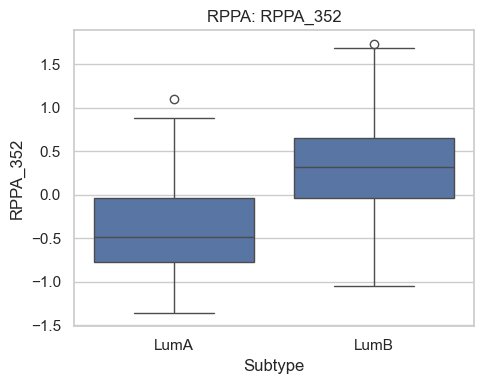

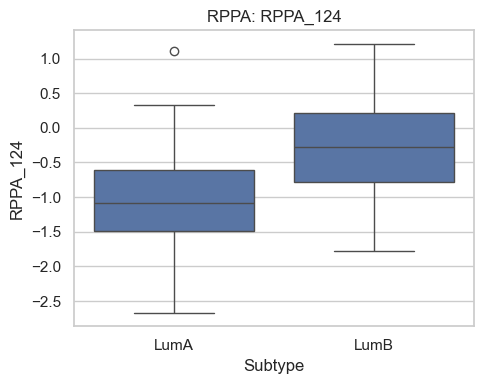

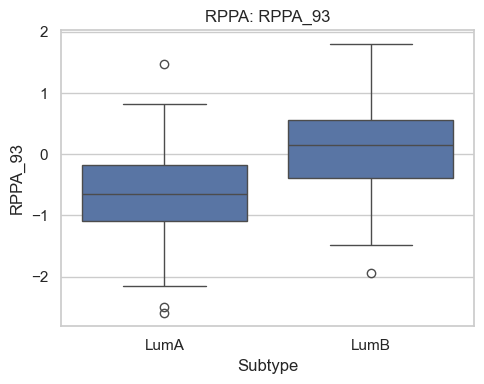

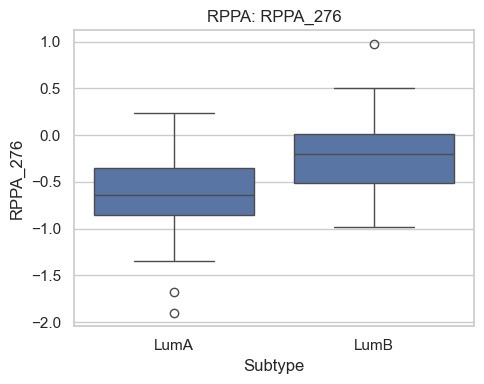

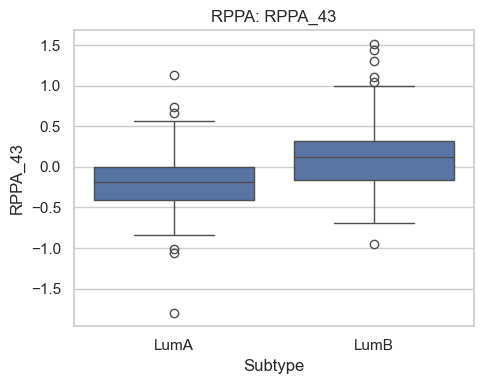

In [ ]:
def plot_feature_distributions(X, y, features_df, view_name, feature_names, topN=5):
    class_names = ["Basal", "Her2", "LumA", "LumB"]
    y_str = np.array([class_names[i] for i in y])
    mask = np.isin(y_str, ["LumA", "LumB"])
    X_sub, y_sub = X[mask], y_str[mask]

    top_feats = features_df.head(topN)["feature"].values
    df = pd.DataFrame(X_sub, columns=feature_names)
    df["Subtype"] = y_sub

    for f in top_feats:
        plt.figure(figsize=(5,4))
        sns.boxplot(x="Subtype", y=f, data=df)
        plt.title(f"{view_name}: {f}")
        plt.tight_layout()
        plt.show()

# Example: mRNA
feature_names_mrna = [f"mRNA_{i}" for i in range(X_mrna.shape[1])]
plot_feature_distributions(X_mrna, y, mrna_features, "mRNA", feature_names_mrna)

# Example: RPPA
feature_names_prot = [f"RPPA_{i}" for i in range(X_prot.shape[1])]
plot_feature_distributions(X_prot, y, prot_features, "RPPA", feature_names_prot)


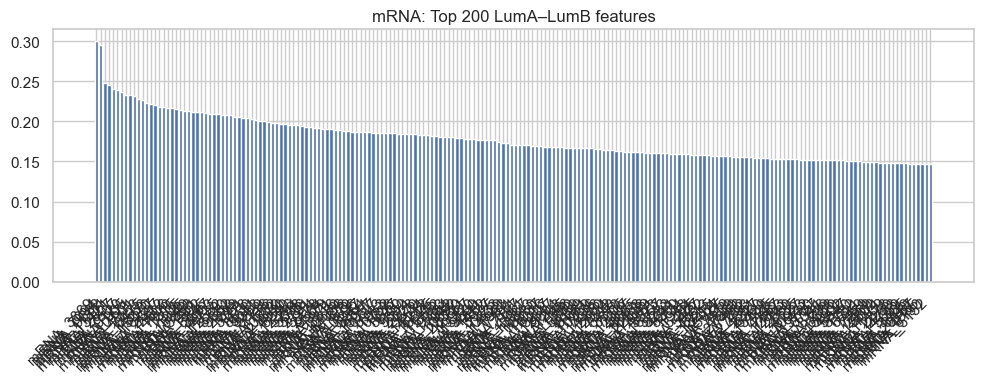

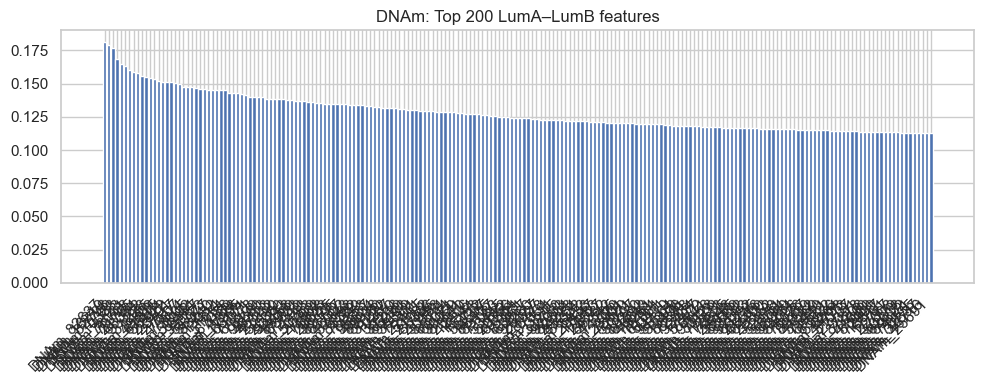

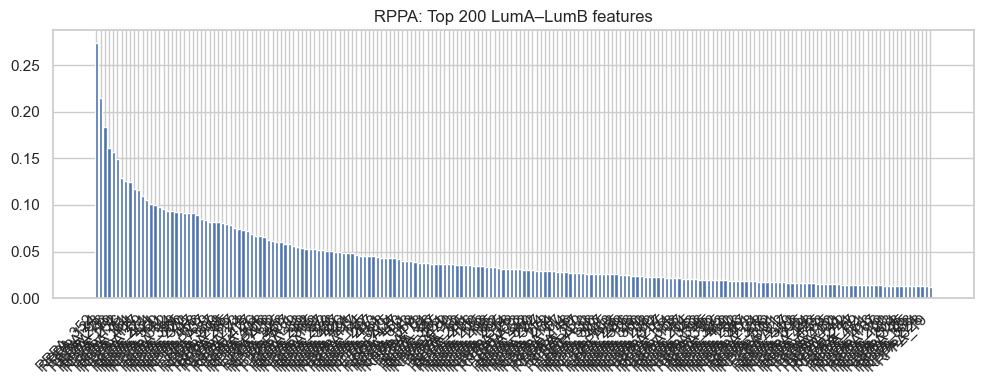

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Identify LumA–LumB–specific features

def anova_lumab(X, y, view_name, feature_names, topN=200):
    class_names = ["Basal", "Her2", "LumA", "LumB"]
    y_str = np.array([class_names[i] for i in y])
    mask = np.isin(y_str, ["LumA", "LumB"])
    X_sub, y_sub = X[mask], y_str[mask]
    F, p = f_classif(X_sub, y_sub)
    F = np.nan_to_num(F, nan=0.0)
    eta2 = ((2 - 1) * F) / (((2 - 1) * F) + (len(y_sub) - 2) + 1e-12)
    df = pd.DataFrame({"feature": feature_names, "eta2": eta2})
    df = df.sort_values("eta2", ascending=False).reset_index(drop=True)
    plt.figure(figsize=(10,4))
    plt.bar(range(topN), df.head(topN)["eta2"])
    plt.xticks(range(topN), df.head(topN)["feature"], rotation=45, ha="right")
    plt.title(f"{view_name}: Top {topN} LumA–LumB features")
    plt.tight_layout()
    plt.show()
    return df.head(topN)

feature_names_mrna = [f"mRNA_{i}" for i in range(X_mrna.shape[1])]
feature_names_meth = [f"DNAm_{i}" for i in range(X_meth.shape[1])]
feature_names_prot = [f"RPPA_{i}" for i in range(X_prot.shape[1])]

mrna_lumab = anova_lumab(X_mrna, y, "mRNA", feature_names_mrna)
meth_lumab = anova_lumab(X_meth, y, "DNAm", feature_names_meth)
prot_lumab = anova_lumab(X_prot, y, "RPPA", feature_names_prot)

lumab_mrna_idx = [int(f.split("_")[1]) for f in mrna_lumab["feature"]]
lumab_meth_idx = [int(f.split("_")[1]) for f in meth_lumab["feature"]]
lumab_prot_idx = [int(f.split("_")[1]) for f in prot_lumab["feature"]]

In [ ]:
# Merge LumA–LumB features with standard ANOVA selection

P1, P2, P3 = X_mrna.shape[1], X_meth.shape[1], X_prot.shape[1]
idx_mrna = list(range(0, P1))
idx_meth = list(range(P1, P1+P2))
idx_prot = list(range(P1+P2, P1+P2+P3))

# define small helper that always keeps LumA–LumB features
class SelectKBestWithLumAB(SelectKBest):
    def __init__(self, score_func=f_classif, k=10, force_idx=None):
        super().__init__(score_func=score_func, k=k)
        self.force_idx = np.array(force_idx) if force_idx is not None else None
    def get_support(self, indices=False):
        base_mask = super().get_support(indices=False)
        if self.force_idx is not None:
            base_mask[self.force_idx] = True
        if indices:
            return np.where(base_mask)[0]
        return base_mask


def view_block(k, force_idx=None):
    return Pipeline([
        ("scale", StandardScaler()),
        ("anova", SelectKBestWithLumAB(f_classif, k=k, force_idx=force_idx))
    ])

K_MRNA, K_METH, K_PROT = 600, 2000, 20  # base K's to start from

pre = ColumnTransformer(
    transformers=[
        ("mrna", view_block(K_MRNA, lumab_mrna_idx), idx_mrna),
        ("meth", view_block(K_METH, lumab_meth_idx), idx_meth),
        ("prot", view_block(K_PROT, lumab_prot_idx), idx_prot),
    ],
    remainder="drop"
)

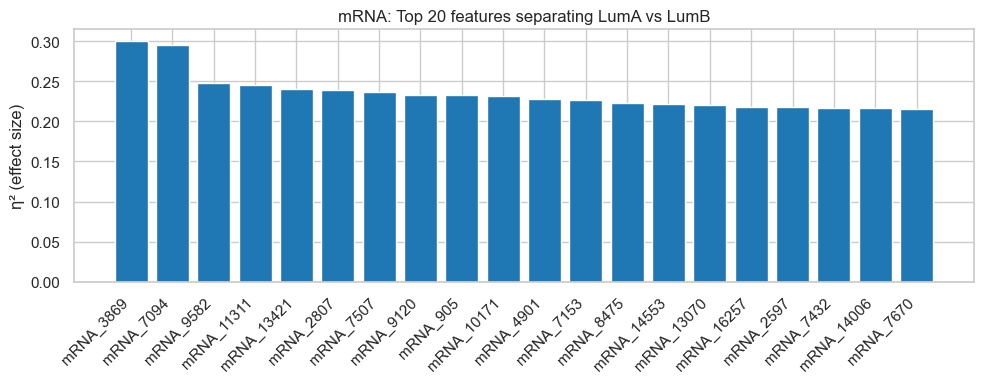

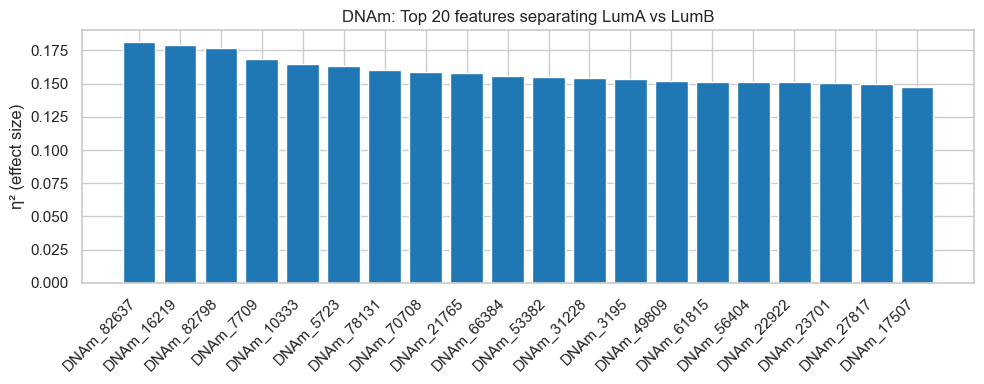

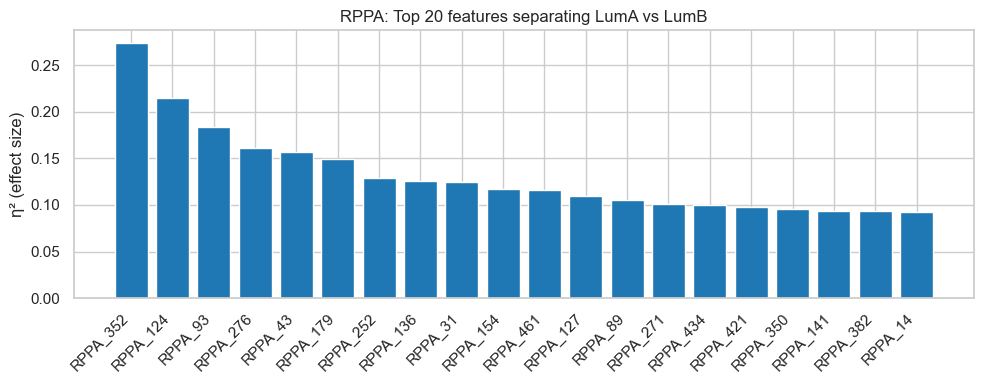

RuntimeError: Cannot clone object SelectKBestWithLumAB(force_idx=array([  0,   1,   0,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,   1,  20,  21,  22,  23,
        24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
        37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,   2,  78,  79,  80,  81,   0,  82,  83,  84,  85,  86,
         1,  87,  88,  89,  90,  91,  92,  93,   2,  94,  95,  96,  97,
        98,  99, 100, 101, 10...
        14, 176, 177,  15, 178, 179, 180,  16,  17, 181, 182,  18, 183,
       184,   5, 185, 186, 187, 188, 189, 190, 191,  19, 192,  20, 193,
        21, 194, 195, 196, 197, 198, 199,  22, 200, 201, 202, 203, 204,
       205,  23,  24, 206, 207, 208,  25,  26,  27,  28,  29, 209, 210,
       211, 212, 213, 214,  30, 215,  31, 216, 217, 218,  32, 219,  33,
       220, 221, 222, 223, 224, 225, 226, 227, 228,  34, 229, 230, 231,
       232, 233,  35,  36, 234, 235,  37,  38, 236, 237, 238, 239, 240,
       241, 242, 243, 244,  39,  40,  41,  42,  43, 245,  44, 246,  45,
       247]),
                     k=600), as the constructor either does not set or modifies parameter force_idx

In [ ]:
# Train L1 logistic regression with CV

cw = dict(
    zip(
        np.unique(y_tr),
        compute_class_weight(class_weight="balanced", classes=np.unique(y_tr), y=y_tr)
    )
)
cw[2] *= 1.2
cw[3] *= 1.2

pipe = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="saga",
        multi_class="multinomial",
        class_weight=cw,
        max_iter=5000,
        n_jobs=-1,
        random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {"clf__C": [0.01, 0.1, 1, 10]}

# Suppose you already have results from earlier:
lumA_lumB_mrna = per_feature_anova_binary(X_mrna, y, "mRNA")
lumA_lumB_meth = per_feature_anova_binary(X_meth, y, "DNAm")
lumA_lumB_prot = per_feature_anova_binary(X_prot, y, "RPPA")

# Concatenate and take top N
lumA_lumB_all = pd.concat([lumA_lumB_mrna, lumA_lumB_meth, lumA_lumB_prot])
force_idx = lumA_lumB_all.sort_values("F", ascending=False).head(300).index.values

# create the selector with force_idx in the constructor
selector = SelectKBestWithLumAB(k=600, force_idx=force_idx)

# pipeline
pipe = Pipeline([
    ('sel', selector),
    ('clf', LogisticRegression(
        penalty='l1',
        solver='liblinear',
        class_weight=cw,
        max_iter=5000,
        random_state=42))
])


gs = GridSearchCV(pipe, param_grid,
                  scoring="balanced_accuracy",
                  cv=cv, n_jobs=-1, verbose=2, refit=True)

gs.fit(Xtr_c, y_tr)

print("Best params:", gs.best_params_)

# Evaluate LumA/LumB performance

y_pred = gs.predict(Xte_c)
print("\nBalanced accuracy:", balanced_accuracy_score(y_te, y_pred).round(3))
print("\nClassification report:")
print(classification_report(y_te, y_pred, digits=3))

cm = confusion_matrix(y_te, y_pred, labels=np.unique(y_te))
print("\nConfusion matrix:\n", pd.DataFrame(cm,
      index=np.unique(y_te), columns=np.unique(y_te)))


### Late integration

In [ ]:
def make_view_lr(k):
    return Pipeline([
        ("scale", StandardScaler()),
        ("kbest", SelectKBest(f_classif, k=k)),
        ("clf", LogisticRegression(
            penalty="l2",
            solver="saga",
            multi_class="multinomial",
            class_weight="balanced",
            max_iter=5000,
            n_jobs=-1,
            random_state=42
        ))
    ])

grid = {"clf__C":[0.01,0.1,1,10,100]}

gs_m = GridSearchCV(make_view_lr(min(K1, P1)), grid, scoring="balanced_accuracy", cv=cv, n_jobs=-1, refit=True).fit(Xtr_m, y_tr)
gs_d = GridSearchCV(make_view_lr(min(K2, P2)), grid, scoring="balanced_accuracy", cv=cv, n_jobs=-1, refit=True).fit(Xtr_d, y_tr)
gs_p = GridSearchCV(make_view_lr(min(K3, P3)), grid, scoring="balanced_accuracy", cv=cv, n_jobs=-1, refit=True).fit(Xtr_p, y_tr)

# average log-probabilities across views

logP = np.log(gs_m.predict_proba(Xte_m) + 1e-12)
logP += np.log(gs_d.predict_proba(Xte_d) + 1e-12)
logP += np.log(gs_p.predict_proba(Xte_p) + 1e-12)
logP /= 3.0

y_pred_lf = logP.argmax(axis=1)

print("LF Balanced Acc:", balanced_accuracy_score(y_te, y_pred_lf).round(3))
print(classification_report(y_te, y_pred_lf, digits=3))

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: F

LF Balanced Acc: 0.837
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        12
           1      0.714     0.833     0.769         6
           2      0.889     0.870     0.879        46
           3      0.647     0.647     0.647        17

    accuracy                          0.840        81
   macro avg      0.813     0.837     0.824        81
weighted avg      0.842     0.840     0.840        81



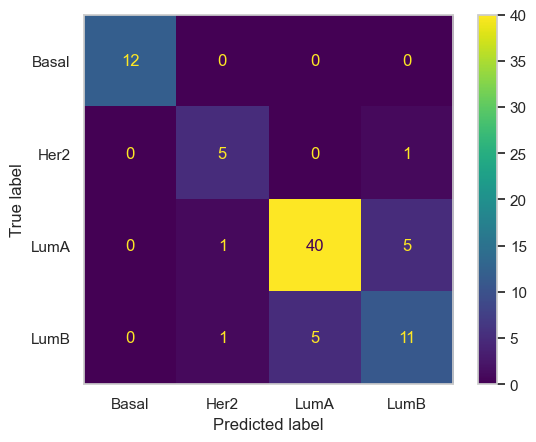

In [ ]:
cm_lf = confusion_matrix(y_te, y_pred_lf)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(cm_lf, display_labels=classes)
disp.plot(ax=ax, cmap="viridis", colorbar=True)
ax.grid(False) 
plt.show()

Performance is not bad, we can look deeper into classes LumA and LumB, and try to get them better. Also we should CV ks, as now they were chosen in a nonsystematic way.

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# cross validating through many features based on etas
K_MRNA_grid = [878, 2623, 7609]        # P1 = 29,995
K_METH_grid = [3154, 8699, 26287]      # P2 = 100,000
K_PROT_grid = [10, 25, 85]             # P3 = 464


KBEST_TRIPLES = list(product(K_MRNA_grid, K_METH_grid, K_PROT_grid))

param_grid = [
    {
        "pre__mrna__kbest__k": [k1],
        "pre__meth__kbest__k": [k2],
        "pre__prot__kbest__k": [k3],
        "clf__C": [0.01, 0.1, 1, 10, 100],
    }
    for (k1, k2, k3) in KBEST_TRIPLES
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    ef,                    
    param_grid=param_grid,
    scoring={"bal_acc": "balanced_accuracy",
             "logloss": "neg_log_loss",
             "auc": "roc_auc_ovr_weighted"},
    refit="bal_acc",
    n_jobs=-1,
    verbose=2
)
gs.fit(Xtr_c, y_tr)

print("Best params:", gs.best_params_)
print("Best CV balanced acc:", gs.best_score_)

NameError: name 'product' is not defined